<a href="https://colab.research.google.com/github/RoyDibs/Rebars-and-debris-Classiffication/blob/master/CNN_RebarsClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and augmenting images
from skimage.io import imread
from skimage.transform import rotate, resize

# for splitting train-test set and evaluating the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# PyTorch libraries 
import torch
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

!unzip images2.zip

Archive:  images2.zip
   creating: images2/
  inflating: images2/0.png           
  inflating: images2/1.png           
  inflating: images2/10.png          
  inflating: images2/100.png         
  inflating: images2/101.png         
  inflating: images2/102.png         
  inflating: images2/103.png         
  inflating: images2/104.png         
  inflating: images2/105.png         
  inflating: images2/106.png         
  inflating: images2/107.png         
  inflating: images2/108.png         
  inflating: images2/109.png         
  inflating: images2/11.png          
  inflating: images2/110.png         
  inflating: images2/111.png         
  inflating: images2/112.png         
  inflating: images2/113.png         
  inflating: images2/114.png         
  inflating: images2/115.png         
  inflating: images2/116.png         
  inflating: images2/117.png         
  inflating: images2/118.png         
  inflating: images2/119.png         
  inflating: images2/12.png          
  infl

In [2]:
train = pd.read_csv('/content/rebars2.csv')

# loading training images
train_img = []
train_img_values = []
for img_name in train['image_names']:
    image_path = '/content/images2/' + img_name
    img = imread(image_path)
    img = img/255
    img = resize(img, output_shape=(3, 224, 224),
                 mode='constant', anti_aliasing=True)
    train_img.append(img)


train_x = np.array(train_img)

# defining the labels
train_y = train['rebars_or_not'].values

train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.2, random_state=13, stratify=train_y)
print("Number of images (Before Image Augmentation) in Training set : ",train_x.shape[0],"  Number of images in Testing set : ",test_x.shape[0])

Number of images (Before Image Augmentation) in Training set :  160   Number of images in Testing set :  41


In [4]:
# Image Augmentation
final_train_x = []
final_train_y = []

#train_x.shape[0]
for i in range(train_x.shape[0]):
    final_train_x.append(train_x[i])
    final_train_x.append(rotate(train_x[i], angle=45, mode = 'wrap'))
    final_train_x.append(np.fliplr(train_x[i]))
    for j in range(3):
      final_train_y.append(train_y[i])

train_x = np.array(final_train_x)
train_y = np.array(final_train_y)
print("Number of images (After Image Augmentation) in Training set : ",train_x.shape[0],"  Number of images in Testing set : ",test_x.shape[0])

Number of images (After Image Augmentation) in Training set :  1440   Number of images in Testing set :  41


In [5]:
# train_x = train_x.numpy()
# train_y = train_y.numpy()
# test_x = test_x.numpy()
# test_y = test_y.numpy()
# converting training images and its labels into torch format
train_x = train_x.reshape(train_x.shape[0], 3, 224, 224) #1956 is the number of training images
train_x  = torch.from_numpy(train_x)
train_x = train_x.float()
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)


# converting test images and its labels into torch format
test_x = test_x.reshape(test_x.shape[0], 3, 224, 224) #164 is the number of test images
test_x  = torch.from_numpy(test_x)
test_x = test_x.float()
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)

In [6]:
# Define the model
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(32),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.25),
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.25),
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.25),
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(p=0.25),
        )

        self.linear_layers = Sequential(
            Linear(128 * 14 * 14, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,10),
            ReLU(inplace=True),
            Dropout(),
            Linear(10,2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [7]:
model = Net()
optimizer = Adam(model.parameters(), lr=0.000075)
criterion = CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [8]:
# batch size of the model
batch_size = 32

# number of epochs to train the model
n_epochs = 50
train_loss1 = np.empty(0)
prediction = []
target = []
accuracy = []
arrc = np.empty(0)

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    permutation = torch.randperm(train_x.size()[0])
    training_loss = []
    for i in range(0,train_x.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            output = model(batch_x.cuda())

        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        prediction.append(predictions)
        target.append(batch_y) 
        
        for i in range(len(prediction)):
            accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))

    arrc = np.append(arrc, np.average(accuracy))
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss, '\t accuracy: \t',np.average(accuracy))
    train_loss1 = np.append(train_loss1, training_loss)


epoch: 	 1 	 training loss: 	 0.6933013002077738 	 accuracy: 	 0.5502717391304348
epoch: 	 2 	 training loss: 	 0.6970394372940063 	 accuracy: 	 0.5517780830280831
epoch: 	 3 	 training loss: 	 0.6818202217419942 	 accuracy: 	 0.5518654684095861
epoch: 	 4 	 training loss: 	 0.6727968586815728 	 accuracy: 	 0.5522617403314917
epoch: 	 5 	 training loss: 	 0.6826399207115174 	 accuracy: 	 0.5553183382497542
epoch: 	 6 	 training loss: 	 0.6596785797013177 	 accuracy: 	 0.5575398045647123
epoch: 	 7 	 training loss: 	 0.6562838580873277 	 accuracy: 	 0.5601592324693591
epoch: 	 8 	 training loss: 	 0.6511792461077373 	 accuracy: 	 0.5624297860880271
epoch: 	 9 	 training loss: 	 0.6290900998645359 	 accuracy: 	 0.5653728030164812
epoch: 	 10 	 training loss: 	 0.635421437687344 	 accuracy: 	 0.5682575757575757
epoch: 	 11 	 training loss: 	 0.6071242829163869 	 accuracy: 	 0.57119404732812
epoch: 	 12 	 training loss: 	 0.6068555573622386 	 accuracy: 	 0.5743579704935989
epoch: 	 13 	 tr

In [9]:
# checking the performance on validation set
torch.manual_seed(0)
n_epochs = 50
val_loss1 = np.empty(0)
prediction = []
target = []
accuracy = []
val_arrc = np.empty(0)

for epoch in range(1, n_epochs+1):

    val_loss = 0.0
    permutation = torch.randperm(test_x.size()[0])
    validation_loss = []
    for i in range(0,test_x.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = test_x[indices], test_y[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        validation_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            output = model(batch_x.cuda())

        softmax = torch.exp(output).cpu()
        prob = list(softmax.numpy())
        predictions = np.argmax(prob, axis=1)
        prediction.append(predictions)
        target.append(batch_y) 
        
        for i in range(len(prediction)):
            accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))

    val_arrc = np.append(val_arrc, np.average(accuracy))
    validation_loss = np.average(validation_loss)
    print('epoch: \t', epoch, '\t validation loss: \t', validation_loss, '\t Val accuracy: \t',np.average(accuracy))
    val_loss1 = np.append(val_loss1, validation_loss)

epoch: 	 1 	 validation loss: 	 4.140457630157471 	 Val accuracy: 	 0.6064814814814815
epoch: 	 2 	 validation loss: 	 1.4774133563041687 	 Val accuracy: 	 0.6250000000000001
epoch: 	 3 	 validation loss: 	 1.2840062975883484 	 Val accuracy: 	 0.6577380952380952
epoch: 	 4 	 validation loss: 	 0.3701983764767647 	 Val accuracy: 	 0.6851851851851852
epoch: 	 5 	 validation loss: 	 0.3696604520082474 	 Val accuracy: 	 0.7079545454545453
epoch: 	 6 	 validation loss: 	 0.40048351138830185 	 Val accuracy: 	 0.7273860398860398
epoch: 	 7 	 validation loss: 	 0.5160999372601509 	 Val accuracy: 	 0.7425264550264551
epoch: 	 8 	 validation loss: 	 0.4252553917467594 	 Val accuracy: 	 0.7519403594771241
epoch: 	 9 	 validation loss: 	 0.21801019459962845 	 Val accuracy: 	 0.7622238466536712
epoch: 	 10 	 validation loss: 	 0.20816372334957123 	 Val accuracy: 	 0.7719907407407407
epoch: 	 11 	 validation loss: 	 0.191034696996212 	 Val accuracy: 	 0.7810166886253843
epoch: 	 12 	 validation loss

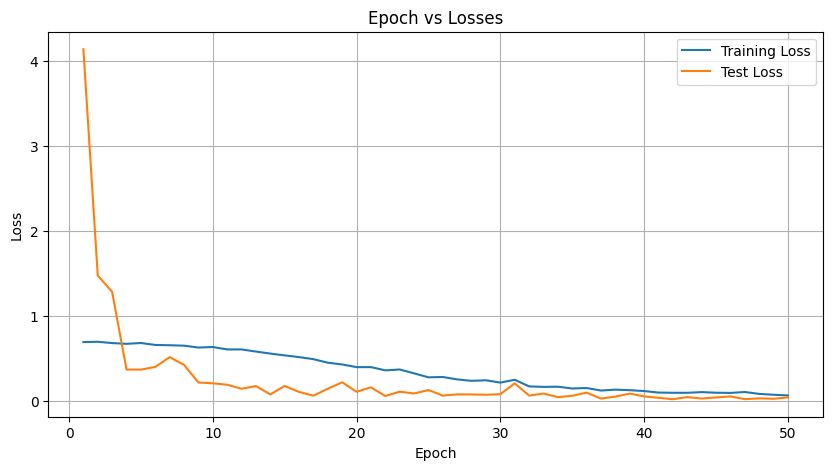

In [10]:
import matplotlib.pyplot as plt
# plot loss and accuracy curves

plt.figure(figsize=(10, 5))
plt.title('Epoch vs Losses')
plt.plot(range(1, n_epochs+1), train_loss1, label='Training Loss')
plt.plot(range(1, n_epochs+1), val_loss1, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

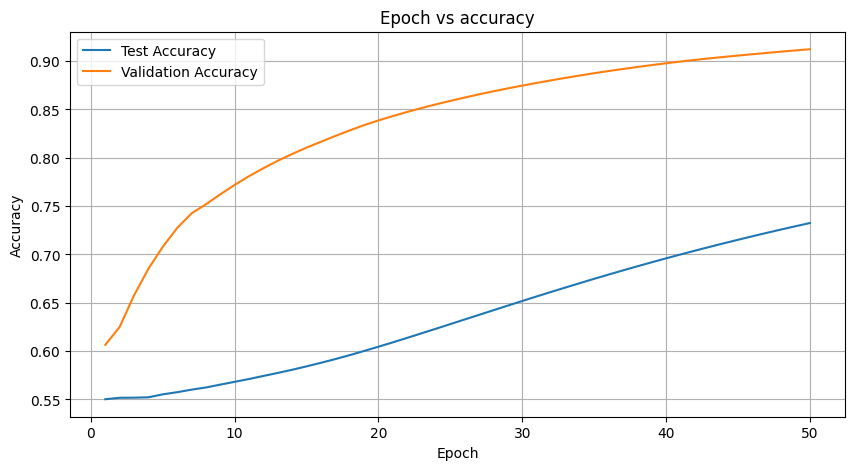

In [11]:
import matplotlib.pyplot as plt
# plot loss and accuracy curves

plt.figure(figsize=(10, 5))
plt.title('Epoch vs accuracy')
plt.plot(range(1, n_epochs+1), arrc, label='Test Accuracy')
plt.plot(range(1, n_epochs+1), val_arrc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [18]:
!unzip check_set.zip

Archive:  check_set.zip
   creating: check_set/
   creating: check_set/debris/
  inflating: check_set/debris/125.png  
  inflating: check_set/debris/134.png  
  inflating: check_set/debris/145.png  
  inflating: check_set/debris/151.png  
  inflating: check_set/debris/98.png  
  inflating: check_set/debris/debristest.jpeg  
   creating: check_set/rebars/
  inflating: check_set/rebars/11.png  
  inflating: check_set/rebars/14.png  
  inflating: check_set/rebars/21.png  
  inflating: check_set/rebars/43.png  
  inflating: check_set/rebars/8.png  
  inflating: check_set/rebars/rebarstest.jpg  


In [50]:
check = pd.read_csv('/content/checkset.csv')

# loading training images
check_img = []
check_img_values = []
for img_name in check['check_img']:
    image_path = '/content/check_set/' + img_name
    img = imread(image_path)
    img = img/255
    img = resize(img, output_shape=(3, 224, 224),
                 mode='constant', anti_aliasing=True)
    check_img.append(img)


check_x = np.array(check_img)

# defining the labels
check_y = check['rebars_or_not'].values

In [51]:
check_x = check_x.reshape(check_x.shape[0], 3, 224, 224) #1956 is the number of training images
check_x  = torch.from_numpy(check_x)
check_x = check_x.float()
check_y = check_y.astype(int)
check_y = torch.from_numpy(check_y)

In [52]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
# batch size of the model
batch_size = 64
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(check_x.size()[0])
for i in range(0,check_x.size()[0], batch_size):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = check_x[indices], check_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):

    accuracy.append(accuracy_score(target[i].cpu(),prediction[i]))

# df_out=pd.DataFrame(zip(target,prediction),columns=['original','predicted'])
# conf_mat=confusion_matrix(df_out['original'],df_out['predicted'])
# import seaborn as sns
# sns.heatmap(conf_mat,annot=True,fmt='.0f',cmap='Blues');
# plt.xlabel("predicted values")
# plt.ylabel("true values")
# plt.title("confusion matrix");
print(target)
print(prediction)

[tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')]
[array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1])]


[[15  5]
 [ 2 18]]


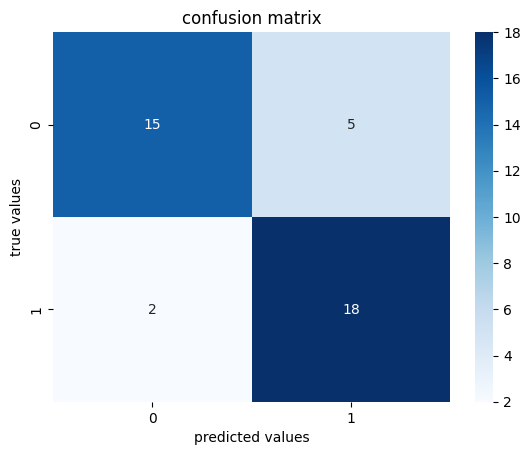

In [53]:
from sklearn.metrics import confusion_matrix

# Convert prediction list to a list of tensors
prediction = [torch.tensor(pred) for pred in prediction]

# Concatenate prediction and target tensors
prediction = torch.cat(prediction)
target = torch.cat(target)

# Calculate confusion matrix
cm = confusion_matrix(target.cpu().numpy(), prediction.numpy())
print(cm)


import seaborn as sns
sns.heatmap(cm,annot=True,fmt='.0f',cmap='Blues');
plt.xlabel("predicted values")
plt.ylabel("true values")
plt.title("confusion matrix");

In [ ]:
model = torch.load('CNN-model.pth')
image_path = '/content/2.png' #Specify the image path
img = imread(image_path)
img = img/255
img = resize(img, output_shape=(3, 224, 224),
               mode='constant', anti_aliasing=True)
img = img.astype('float32')
img = np.array(img)

img = img.reshape(1, 3, 224, 224) 
img = torch.from_numpy(img)
img = img.float()

output = model(img.cuda())
softmax = torch.exp(output).cpu()
prob = list(softmax.detach().numpy())
predictions = np.argmax(prob, axis=1)
print(predictions)
if predictions == 0:
  print('Image contains debris')
else:
  print('Image contains rebars')


[1]
Image contains rebars
